In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Hamiltonian Neural Network
class HamiltonianNN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)  # Output: H(q, p)
        )

    def forward(self, q, p):
        state = torch.cat((q, p), dim=1)  # Concatenate q and p
        return self.net(state)


In [2]:
# Function to compute time derivatives using the learned Hamiltonian
def compute_time_derivatives(model, q, p):
    q.requires_grad_(True)
    p.requires_grad_(True)

    H = model(q, p)  # Compute Hamiltonian

    # Compute derivatives using autograd
    dH_dq = torch.autograd.grad(H, q, grad_outputs=torch.ones_like(H), create_graph=True)[0]
    dH_dp = torch.autograd.grad(H, p, grad_outputs=torch.ones_like(H), create_graph=True)[0]

    dq_dt = dH_dp
    dp_dt = -dH_dq

    return dq_dt, dp_dt

# Generate synthetic training data (Pendulum data)
def generate_pendulum_data(n_samples=1000, noise=0.0):
    q = np.linspace(-np.pi, np.pi, n_samples)  # Angle theta
    p = np.linspace(-2, 2, n_samples)  # Momentum

    q, p = np.meshgrid(q, p)
    q, p = q.ravel(), p.ravel()

    # True Hamiltonian for a pendulum
    m, g, l = 1.0, 9.81, 1.0
    H_true = (p**2 / (2 * m * l**2)) + m * g * l * (1 - np.cos(q))

    # Compute derivatives
    dq_dt = p / (m * l**2)
    dp_dt = -m * g * l * np.sin(q)

    # Add noise (optional)
    dq_dt += noise * np.random.randn(*dq_dt.shape)
    dp_dt += noise * np.random.randn(*dp_dt.shape)

    return q, p, dq_dt, dp_dt, H_true

# Convert data to PyTorch tensors
def prepare_data():
    q, p, dq_dt, dp_dt, _ = generate_pendulum_data()

    q = torch.tensor(q, dtype=torch.float32).view(-1, 1).to(device)
    p = torch.tensor(p, dtype=torch.float32).view(-1, 1).to(device)
    dq_dt = torch.tensor(dq_dt, dtype=torch.float32).view(-1, 1).to(device)
    dp_dt = torch.tensor(dp_dt, dtype=torch.float32).view(-1, 1).to(device)

    return q, p, dq_dt, dp_dt


In [4]:
# Training function
def train_hnn(model, q, p, dq_dt_true, dp_dt_true, epochs=5000, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        optimizer.zero_grad()

        dq_dt_pred, dp_dt_pred = compute_time_derivatives(model, q, p)

        loss = loss_fn(dq_dt_pred, dq_dt_true) + loss_fn(dp_dt_pred, dp_dt_true)
        loss.backward()
        optimizer.step()

        if epoch % 50 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

# Initialize and train the model
model = HamiltonianNN().to(device)
q, p, dq_dt_true, dp_dt_true = prepare_data()
train_hnn(model, q, p, dq_dt_true, dp_dt_true)


Epoch 0: Loss = 49.978214
Epoch 50: Loss = 44.599838
Epoch 100: Loss = 31.845350
Epoch 150: Loss = 20.098829
Epoch 200: Loss = 13.934344
Epoch 250: Loss = 10.153500
Epoch 300: Loss = 7.565677
Epoch 350: Loss = 5.730624
Epoch 400: Loss = 4.397599
Epoch 450: Loss = 3.428812
Epoch 500: Loss = 2.697982
Epoch 550: Loss = 1.804302
Epoch 600: Loss = 1.409672
Epoch 650: Loss = 1.128467
Epoch 700: Loss = 0.918331
Epoch 750: Loss = 0.756851
Epoch 800: Loss = 0.629931
Epoch 850: Loss = 0.527845
Epoch 900: Loss = 0.443997
Epoch 950: Loss = 0.373960
Epoch 1000: Loss = 0.316646
Epoch 1050: Loss = 0.273018
Epoch 1100: Loss = 0.240194
Epoch 1150: Loss = 0.215025
Epoch 1200: Loss = 0.195445
Epoch 1250: Loss = 0.179967
Epoch 1300: Loss = 0.167529
Epoch 1350: Loss = 0.157395
Epoch 1400: Loss = 0.149039
Epoch 1450: Loss = 0.142044
Epoch 1500: Loss = 0.136063
Epoch 1550: Loss = 0.130808
Epoch 1600: Loss = 0.126038
Epoch 1650: Loss = 0.121542
Epoch 1700: Loss = 0.117115
Epoch 1750: Loss = 0.112526
Epoch 180

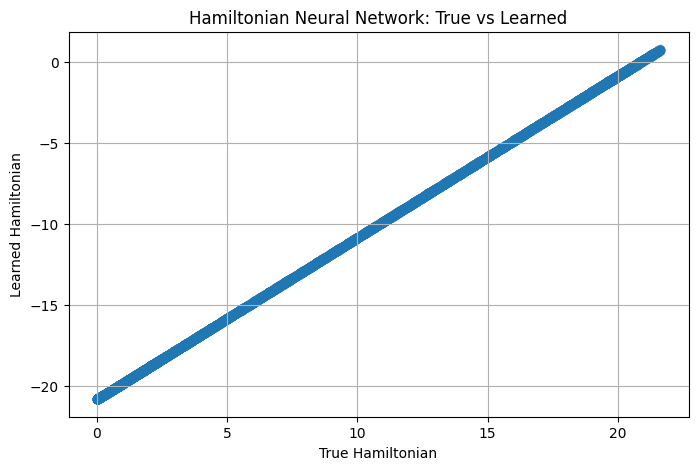

In [5]:
# Evaluate learned Hamiltonian
q_test, p_test, _, _, H_true = generate_pendulum_data(n_samples=100)
q_test = torch.tensor(q_test, dtype=torch.float32).view(-1, 1).to(device)
p_test = torch.tensor(p_test, dtype=torch.float32).view(-1, 1).to(device)

H_learned = model(q_test, p_test).cpu().detach().numpy()

# Plot results
plt.figure(figsize=(8, 5))
plt.scatter(H_true, H_learned, alpha=0.5)
plt.xlabel("True Hamiltonian")
plt.ylabel("Learned Hamiltonian")
plt.title("Hamiltonian Neural Network: True vs Learned")
plt.grid()
plt.show()


RuntimeError: mat1 and mat2 shapes cannot be multiplied (40x80 and 2x32)